In [190]:
import io
import re
import os
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [191]:
class FacebookIO(io.FileIO):
    def read(self, size: int = -1) -> bytes:
        data: bytes = super(FacebookIO, self).readall()
        new_data: bytes = b''
        i: int = 0
        while i < len(data):
            # \u00c4\u0085
            # 0123456789ab
            if data[i:].startswith(b'\\u00'):
                u: int = 0
                new_char: bytes = b''
                while data[i+u:].startswith(b'\\u00'):
                    hex = int(bytes([data[i+u+4], data[i+u+5]]), 16)
                    new_char = b''.join([new_char, bytes([hex])])
                    u += 6

                char : str = new_char.decode('utf-8')
                new_chars: bytes = bytes(json.dumps(char).strip('"'), 'ascii')
                new_data += new_chars
                i += u
            else:
                new_data = b''.join([new_data, bytes([data[i]])])
                i += 1

        return new_data

In [192]:
def convert_timestamp(timestamp):
    # Convert timestamp to seconds (if it's in milliseconds)
    timestamp = timestamp if timestamp > 1_000_000_000 else timestamp / 1_000
    # Create a datetime object from the timestamp
    dt = datetime.datetime.fromtimestamp(timestamp)
    # Format the datetime object to a readable string
    return dt.strftime('%Y-%m')

In [193]:
def std_time_df(raw_dict):  
    #Define start and end dates
    start_date = datetime.date(2019, 5, 1)
    end_date = datetime.date(2024, 6, 30)

    # Create an empty list to store formatted dates
    date_list = []

    # Iterate over days between start and end dates (inclusive)
    current_date = start_date
    while current_date <= end_date:
        # Format the current date to include only year and month (YYYY-MM format)
        formatted_date = current_date.strftime('%Y-%m')
        date_list.append(formatted_date)
        current_date += datetime.timedelta(days=1)

    # Print the list of formatted dates
    month_list = list(tuple(set(i for i in date_list)))
    
    count_values=[]

    for month in month_list:
        if month not in raw_dict["time"]:
            raw_dict["time"].append(month)
            raw_dict["count_values"].append(0)
    return pd.DataFrame(raw_dict).sort_values("time")



## Number of friends added each months

In [194]:
f = FacebookIO("data/connections/friends/your_friends.json", "rb")
friends_data = json.load(f)

timestamp_list = []
for person in friends_data["friends_v2"]:
    timestamp_list.append(convert_timestamp(person["timestamp"]))
unique_timestamp = tuple(set(e for e in timestamp_list))

In [195]:
num_friends = []

for time in unique_timestamp:
    count = 0
    for person in friends_data["friends_v2"]:
        if convert_timestamp(person["timestamp"]) == time:
            count += 1
    num_friends.append(count)
raw_friends_dict = {"time": list(unique_timestamp), "count_values": num_friends}
friends_dict = std_time_df(raw_friends_dict)


Text(0.5, 1.0, 'Number of friends added each months')

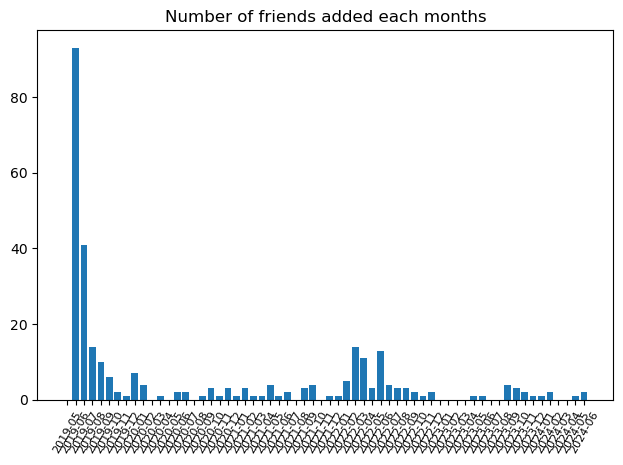

In [196]:
plt.bar(friends_dict["time"], friends_dict["count_values"], width=0.8)
plt.subplots_adjust(left=0.1, right=1)
plt.tick_params(axis="x", rotation=60, labelsize=8)
plt.title("Number of friends added each months")

## Comment and Like Frequency over the months

In [197]:
#comments
cmt_data = FacebookIO("data/your_facebook_activity/comments_and_reactions/comments.json", "rb")
cmt_data = json.load(cmt_data)

cmt_timestamp_list = []
for cmt in cmt_data["comments_v2"]:
    cmt_timestamp_list.append(convert_timestamp(cmt["timestamp"]))
cmt_unique_timestamp = tuple(set(e for e in cmt_timestamp_list))

num_cmt = []
for time in cmt_unique_timestamp:
    count = 0
    for person in cmt_data["comments_v2"]:
        if convert_timestamp(person["timestamp"]) == time:
            count += 1
    num_cmt.append(count)
raw_cmt_dict = {"time": list(cmt_unique_timestamp), "count_values": num_cmt}
cmt_df = std_time_df(raw_cmt_dict)

In [198]:
#likes and reactions
l_data_1 = FacebookIO("data/your_facebook_activity/comments_and_reactions/likes_and_reactions_1.json", "rb")
l_data_2 = FacebookIO("data/your_facebook_activity/comments_and_reactions/likes_and_reactions_2.json", "rb")
l_data_1 = json.load(l_data_1)
l_data_2 = json.load(l_data_2)
react_data = l_data_1+l_data_2

In [199]:
# check unique reactions
react_list = []
for react in react_data:
    if react["data"][0]["reaction"]["reaction"] != "":
        react_list.append(react["data"][0]["reaction"]["reaction"])
react_unique_list = list(tuple(set(react_list)))


In [200]:
sorry_count=[]
wow_count=[]
like_count=[]
haha_count=[]
anger=[]
support=[]
love_count=[]
react_timestamp_list = []

for react in react_data:
    react_timestamp_list.append(convert_timestamp(react["timestamp"]))
react_unique_timestamp = tuple(set(e for e in react_timestamp_list))
len(react_unique_timestamp)

def std_react_dict(react: str):
    num_react = []
    for time in react_unique_timestamp:
        count = 0
        for activate in react_data:
            if (activate["data"][0]["reaction"]["reaction"] == react) and (convert_timestamp(activate["timestamp"]) == time):
                count += 1
        num_react.append(count)
    return std_time_df({"time": list(react_unique_timestamp), "count_values": num_react})

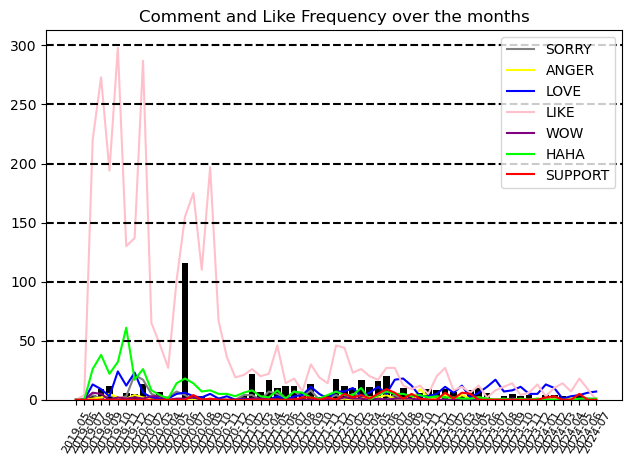

In [201]:
color_list = ['gray', 'yellow', 'blue', 'pink', 'purple', 'lime', 'red']
for react, color in zip(react_unique_list, color_list):
    react_dict = std_react_dict(react)
    plt.plot(react_dict["time"], react_dict["count_values"], color=color, label=react)
plt.bar(cmt_df["time"], cmt_df["count_values"], color="black")
plt.subplots_adjust(left=0.1, right=1)
plt.tick_params(axis="x", rotation=60, labelsize=8)
plt.title("Comment and Like Frequency over the months")
plt.axhline(50, color='black', linestyle='--')
plt.axhline(100, color='black', linestyle='--')
plt.axhline(150, color='black', linestyle='--')
plt.axhline(200, color='black', linestyle='--')
plt.axhline(250, color='black', linestyle='--')
plt.axhline(300, color='black', linestyle='--')
plt.legend()

## Number of Messages and Unique Participants per Month

In [202]:
# show number of json file in folder `data/your_facebook_activity/messages/inbox`
inbox_path = "data/your_facebook_activity/messages/inbox"
json_files = []
for inbox in os.listdir(inbox_path):
    for filename in os.listdir(os.path.join(inbox_path, inbox)):
        if filename.endswith(".json"):
            json_files.append("{}/{}".format(inbox, filename))

json_files

['hetdichdiannha_4255320804511502/message_1.json',
 'dothithuytrang_1101508970630463/message_1.json',
 'trieudaimanvuonghaumdcver18_2120922594616891/message_1.json',
 'phungdinhvan_719538078450775/message_1.json',
 'trithanhtrithanh_655013428339333/message_1.json',
 'olympicly1120192020_2377122785684887/message_1.json',
 'kristinavamy_6433051760115299/message_1.json',
 'lopi112022_5922010531184621/message_1.json',
 'nguyendangtrungkien_733916344302721/message_1.json',
 'nguyenphamminhtri_580892936544020/message_1.json',
 'sansaleshopee1_25047381034908315/message_1.json',
 'nghihue_145898449806891/message_1.json',
 '11cla2_2200445800034248/message_1.json',
 'kichikichi_712740743359238/message_1.json',
 'doicongtacxahoigeopet_600870027879644/message_1.json',
 'nguoidungfacebook_2184269145197555/message_1.json',
 'khoitran_113111819988803/message_1.json',
 'minhnguyen_802782654355046/message_1.json',
 'tranvinhthuyduong_157870565361182/message_1.json',
 'nguyenthanhphat_1489261664859716/m

In [203]:
mess_timestamp_list = []
mess_content_list = []
for message_path in json_files:
    mess_content = FacebookIO(os.path.join(inbox_path, message_path))
    mess_content = json.load(mess_content)
    mess_content_list.append(mess_content)
    for mess in mess_content["messages"]:
        mess_timestamp_list.append(convert_timestamp(mess["timestamp_ms"]//1000))
mess_unique_timestamp = tuple(set(e for e in mess_timestamp_list))
mess_unique_timestamp

('2021-09',
 '2020-08',
 '2021-06',
 '2021-04',
 '2020-12',
 '2020-04',
 '2020-01',
 '2021-03',
 '2024-05',
 '2023-09',
 '2022-10',
 '2021-02',
 '2024-03',
 '2023-01',
 '2019-01',
 '2019-07',
 '2020-02',
 '2022-12',
 '2019-06',
 '2021-12',
 '2019-08',
 '2024-07',
 '2019-03',
 '2023-04',
 '2020-03',
 '2022-03',
 '2021-01',
 '2021-05',
 '2020-07',
 '2023-11',
 '2023-03',
 '2024-04',
 '2019-04',
 '2020-09',
 '2019-10',
 '2019-12',
 '2022-02',
 '2022-11',
 '2023-08',
 '2024-02',
 '2024-01',
 '2022-06',
 '2023-06',
 '2019-02',
 '2021-07',
 '2021-11',
 '2020-05',
 '2024-06',
 '2022-01',
 '2022-09',
 '2022-07',
 '2023-07',
 '2021-10',
 '2019-11',
 '2023-02',
 '2023-12',
 '2022-04',
 '2022-05',
 '2021-08',
 '2023-05',
 '2022-08',
 '2019-09',
 '2023-10',
 '2020-10',
 '2018-12',
 '2020-06',
 '2019-05',
 '2020-11')

In [204]:
num_mess = []
for time in mess_unique_timestamp:
    count = 0
    for mess_content in mess_content_list:
        for mess in mess_content["messages"]:
            if (mess["sender_name"] == "Khoi Tran") and (convert_timestamp(mess["timestamp_ms"]//1000) == time):
                count += 1
    num_mess.append(count)
raw_mess_dict = {"time": list(mess_unique_timestamp), "count_values": num_mess}
mess_dict = std_time_df(raw_mess_dict)
mess_dict


            

,time,count_values
64,2018-12,0
14,2019-01,0
43,2019-02,0
22,2019-03,0
32,2019-04,0
...,...,...
12,2024-03,26
31,2024-04,2
8,2024-05,65
47,2024-06,6


Text(0.5, 1.0, 'Number of messages per month')

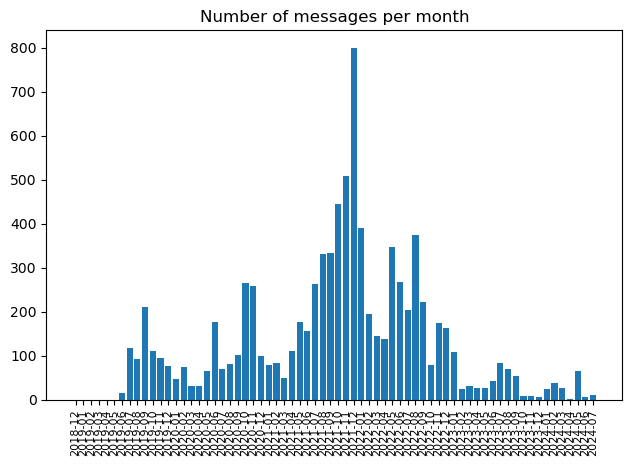

In [205]:
plt.bar(mess_dict["time"], mess_dict["count_values"], width=0.8)
plt.subplots_adjust(left=0.1, right=1)
plt.tick_params(axis="x", rotation=90, labelsize=8)
plt.title("Number of messages per month")

## Top 50 Words Used in My Vietnamese Messages

In [206]:
mess_ak = []
for mess_content_full in mess_content_list:
    for mess in mess_content_full["messages"]:
        if mess["sender_name"] == "Khoi Tran" and "content" in mess:
            mess_ak.append(mess["content"])

def split_into_words(sentence):
    # Remove punctuation and special characters
    sentence = re.sub(r'[^\w\s]', '', sentence)

    # Split the sentence into words based on whitespace
    words = sentence.split()

    words = [word.lower() for word in words]

    return words

words_list = []
for sentence in mess_ak:
    words_list.extend(split_into_words(sentence))

words_list_unique = tuple(set(words_list))

words_num = []
for word_unique in words_list_unique:
    count = 0
    for word in words_list:
        if word == word_unique:
            count += 1
    words_num.append(count)

word_dict = pd.DataFrame({"word": list(words_list_unique), "count_values": words_num})
word_dict = word_dict.sort_values(by="count_values", ascending=True)

Text(0.5, 1.0, 'Top 50 Words Used in My Vietnamese Messages')

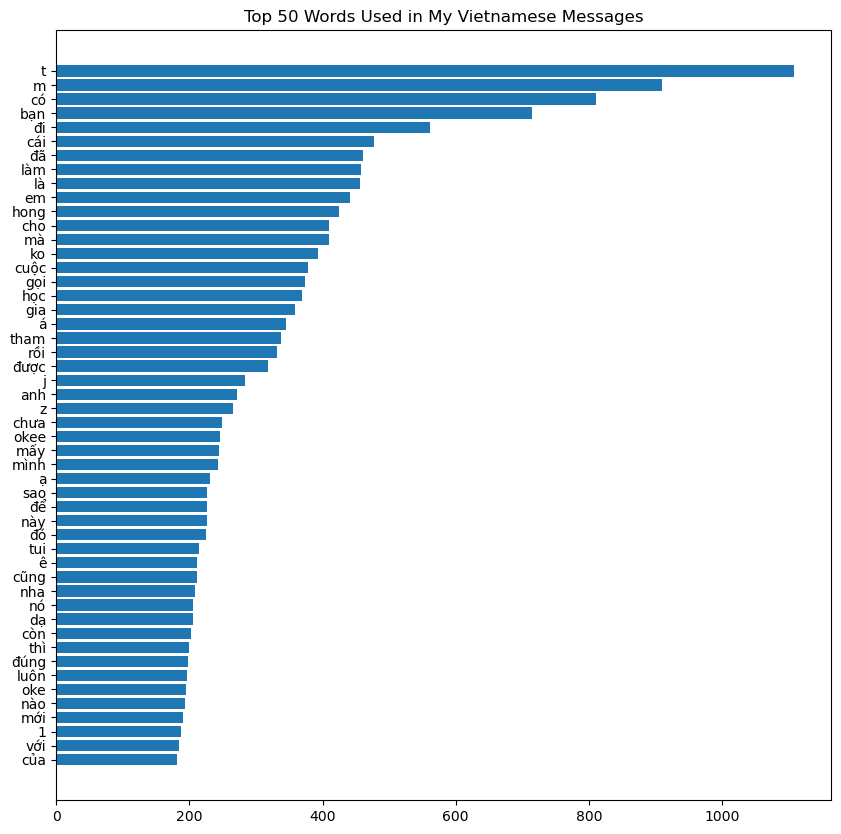

In [207]:
word_dict_50 = word_dict.tail(50)
plt.figure(figsize=(10, 10))
plt.barh(word_dict_50["word"], word_dict_50["count_values"])
plt.title("Top 50 Words Used in My Vietnamese Messages")